# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time

Hyperparameters

In [2]:
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = 120
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY=3e-4

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"Using device: {DEVICE}")
print(f"Random seed: {RANDOM_SEED}")

Using device: cuda
Random seed: 42


# Download Dataset

In [4]:
# ============================================
# KAGGLE DATASET DOWNLOAD (OPTION 1)
# ============================================

!pip install -q kaggle

# Upload kaggle.json (only need to run once per session)
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Dog Breed dataset
print("\nDownloading Dog Breed dataset from Kaggle...")
!kaggle datasets download -d miljan/stanford-dogs-dataset-traintest


# Unzip dataset
print("\nExtracting dataset...")
!unzip stanford-dogs-dataset-traintest.zip -d dog_dataset

print("✅ Dataset downloaded and extracted successfully!\n")

Please upload your kaggle.json file:


Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1200.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1270.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1299.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1318.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1409.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_158.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1615.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1622.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1669.jpg  
  inflating: dog_dataset/cropped/train/n02102973-Irish_water_spaniel/n02102973_1714.jpg  
  inflating: dog_dataset/cropped/train/n02102973-I

# Train and Validation function

In [5]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0]).to(x.device)

    target_a = y
    target_b = y[rand_index]

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))

    return x, target_a, target_b, lam

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc


class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_val_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_val_acc + self.min_delta:
            self.best_val_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# Data Augmentation

In [6]:
# Data transforms for validation/test (no augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet stats
])

# Data transforms for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    # Geometric augmentations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    # Color augmentations
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),

    # Blur
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),

    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

    # Random Erasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
])

# Load training data
TRAIN_ROOT = "dog_dataset/cropped/train"
TEST_ROOT = "dog_dataset/cropped/test"

train_full = ImageFolder(TRAIN_ROOT, transform=train_transform)

# Get breed names
BREED_LABELS = train_full.classes
print(f"Number of breeds: {len(BREED_LABELS)}")
print(f"First 5 breeds: {BREED_LABELS[:5]}")

# Split training into train (90%) and validation (10%)
val_ratio = 0.1
num_train = len(train_full)
num_val = int(num_train * val_ratio)
num_train_final = num_train - num_val

train_ds, val_ds = random_split(
    train_full,
    [num_train_final, num_val],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

# Override val transform (no augmentation)
val_ds.dataset.transform = transform

# Load test data
test_ds = ImageFolder(TEST_ROOT, transform=transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Print dataset info
print(f"\nDataset Split Summary:")
print(f"{'='*60}")
print(f"Training samples: {len(train_ds)} ({len(train_ds)/len(train_full)*100:.1f}%)")
print(f"Validation samples: {len(val_ds)} ({len(val_ds)/len(train_full)*100:.1f}%)")
print(f"Test samples: {len(test_ds)}")
print(f"Total samples: {len(train_full) + len(test_ds)}")
print(f"{'='*60}\n")


Number of breeds: 120
First 5 breeds: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu']

Dataset Split Summary:
Training samples: 10800 (90.0%)
Validation samples: 1200 (10.0%)
Test samples: 8580
Total samples: 20580



# Visualizing Data

Sample images from training set:


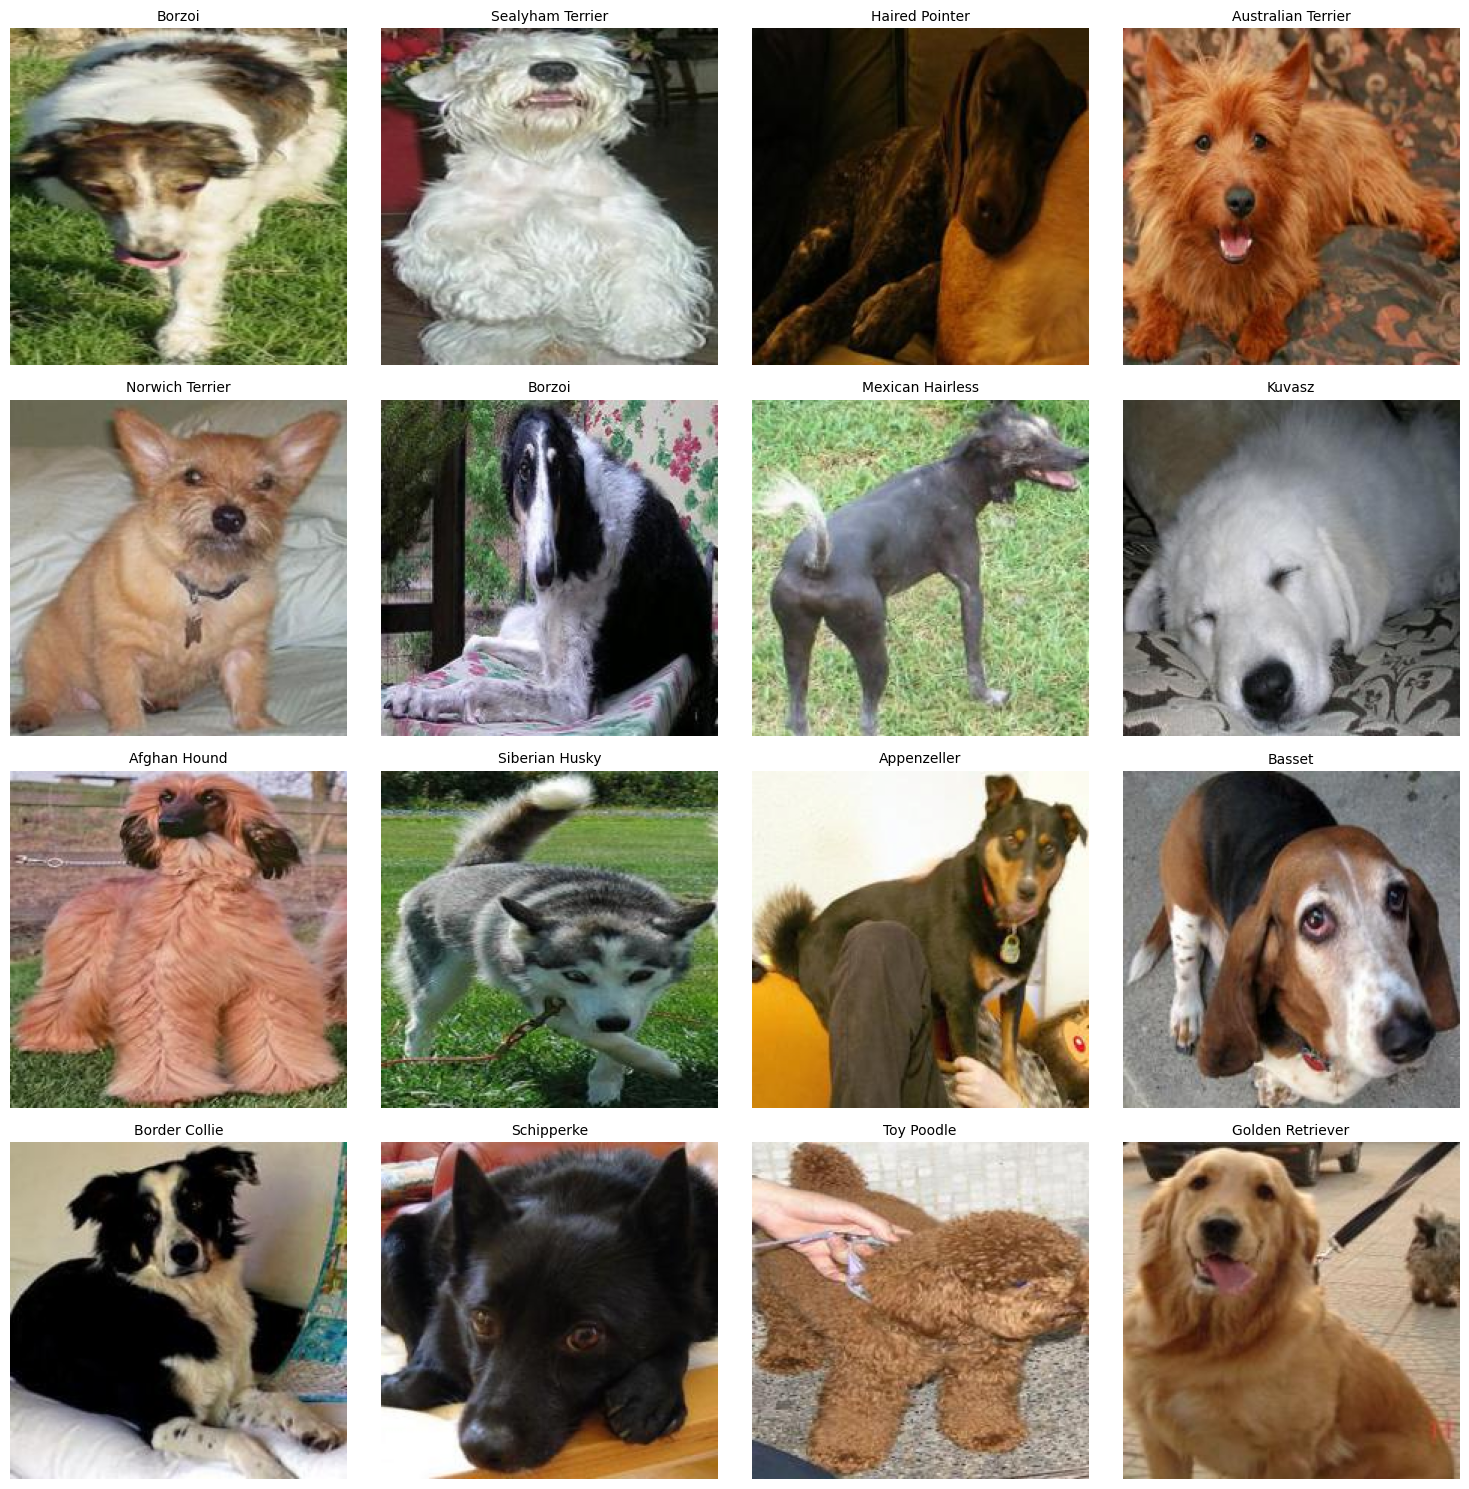

In [7]:
def visualize_batch(loader, breed_labels, n_images=16):
    """
    Visualize a batch of images from the dataset
    """
    images, labels = next(iter(loader))

    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(min(n_images, len(images))):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img)
        # Clean up breed name
        breed_name = breed_labels[labels[i]].split('-')[-1].replace('_', ' ').title()
        axes[i].set_title(f'{breed_name}', fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some training samples
print("Sample images from training set:")
visualize_batch(train_loader, BREED_LABELS)

# Evaluation functions

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns

def evaluate_model(model, loader, breed_labels, model_name="Model"):
    """
    Comprehensive evaluation of a model.
    Returns: accuracy, confusion matrix, and classification metrics
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Overall accuracy
    accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None
    )

    print(f"\n{'='*60}")
    print(f"{model_name} - Test Results")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"\nPer-Class Metrics (Top 10 breeds by F1-Score):")
    print(f"{'-'*60}")
    print(f"{'Breed':<30} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print(f"{'-'*60}")

    # Sort by F1 score and show top 10
    sorted_indices = np.argsort(f1)[::-1][:10]
    for i in sorted_indices:
        breed_name = breed_labels[i].split('-')[-1].replace('_', ' ').title()
        print(f"{breed_name:<30} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f}")

    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)
    print(f"{'-'*60}")
    print(f"{'Average (all classes)':<30} {avg_precision:<12.4f} {avg_recall:<12.4f} {avg_f1:<12.4f}")
    print(f"{'='*60}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'support': support
    }


def measure_inference_time(model, loader, num_batches=10):
    """
    Measure average inference time per batch
    """
    model.eval()
    times = []

    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches:
                break

            images = images.to(DEVICE)

            # Measure time
            start_time = time.time()
            _ = model(images)
            end_time = time.time()

            times.append(end_time - start_time)

    avg_time = np.mean(times) * 1000  # Convert to milliseconds
    return avg_time


def count_parameters(model):
    """
    Count total and trainable parameters
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


def plot_training_curves(history, model_name="Model"):
    """
    Plot training and validation loss/accuracy curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
    ax1.set_title(f'{model_name} - Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
    ax2.set_title(f'{model_name} - Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# The CNN model

In [9]:
class DogBreedCNN(nn.Module):
    def __init__(self, num_classes=120):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(0.1)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout2d(0.2)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout2d(0.3)

        # Block 4
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.drop4 = nn.Dropout2d(0.4)

        # Classifier
        self.fc1 = nn.Linear(256 * 14 * 14, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.drop3(x)

        # Block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)
        x = self.drop4(x)

        # Classifier
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Initialize model
model = DogBreedCNN(num_classes=NUM_CLASSES).to(DEVICE)
model_name = "DogBreedCNN"

# Print model info
total_params, trainable_params = count_parameters(model)
print(f"\n{model_name} Model Info:")
print(f"{'='*60}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")
print(f"{'='*60}\n")


DogBreedCNN Model Info:
  Total parameters: 6,827,768
  Trainable parameters: 6,827,768
  Model size: 26.05 MB (float32)



# Training Setup

In [10]:
# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print("✅ Training setup complete!")
print(f"Loss function: CrossEntropyLoss with class weights and label smoothing")
print(f"Optimizer: Adam (lr={LEARNING_RATE}, weight_decay=5e-5)")
print(f"Scheduler: StepLR (step_size=10, gamma=0.5)")

✅ Training setup complete!
Loss function: CrossEntropyLoss with class weights and label smoothing
Optimizer: Adam (lr=0.001, weight_decay=5e-5)
Scheduler: StepLR (step_size=10, gamma=0.5)


# Training loop


Training DogBreedCNN

Epoch 01/50 | Train Loss: 4.7452 | Train Acc: 1.87% | Val Loss: 4.4875 | Val Acc: 3.33%
Epoch 02/50 | Train Loss: 4.4794 | Train Acc: 3.93% | Val Loss: 4.3601 | Val Acc: 5.00%
Epoch 03/50 | Train Loss: 4.3573 | Train Acc: 5.41% | Val Loss: 4.2450 | Val Acc: 7.33%
Epoch 04/50 | Train Loss: 4.2658 | Train Acc: 6.56% | Val Loss: 4.1699 | Val Acc: 9.33%
Epoch 05/50 | Train Loss: 4.1809 | Train Acc: 8.33% | Val Loss: 4.1048 | Val Acc: 10.33%
Epoch 06/50 | Train Loss: 4.1060 | Train Acc: 9.86% | Val Loss: 4.0445 | Val Acc: 10.67%
Epoch 07/50 | Train Loss: 4.0462 | Train Acc: 10.80% | Val Loss: 3.9984 | Val Acc: 10.83%
Epoch 08/50 | Train Loss: 3.9880 | Train Acc: 12.50% | Val Loss: 3.9577 | Val Acc: 11.75%
Epoch 09/50 | Train Loss: 3.9294 | Train Acc: 13.15% | Val Loss: 3.9195 | Val Acc: 11.58%
EarlyStopping counter: 1/10
Epoch 10/50 | Train Loss: 3.8648 | Train Acc: 14.56% | Val Loss: 3.8978 | Val Acc: 14.42%
Epoch 11/50 | Train Loss: 3.7995 | Train Acc: 15.73% | Val 

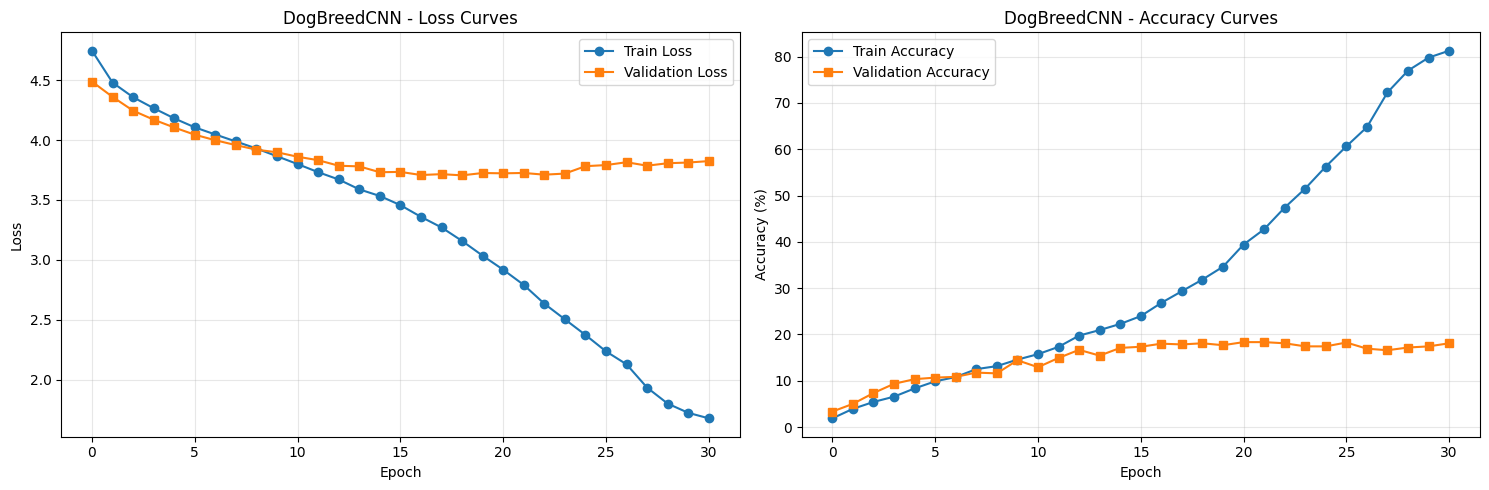

In [11]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Training
best_val_acc = 0.0
best_epoch = 0

print(f"\n{'='*60}")
print(f"Training {model_name}")
print(f"{'='*60}\n")

early_stopping = EarlyStopping(patience=10, min_delta=0.001)

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), f'{model_name}_best.pth')

    # Print progress
    print(f'Epoch {epoch+1:02d}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    if early_stopping(val_acc):
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

    scheduler.step(val_acc)

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"{'='*60}\n")

# Plot training curves
plot_training_curves(history, model_name)

# Evaluating Model

In [12]:
# Load best model
model.load_state_dict(torch.load(f'{model_name}_best.pth'))

# Evaluate on test set
print("\nEvaluating on Test Set...")
results = evaluate_model(model, test_loader, BREED_LABELS, model_name)

# Measure inference time
avg_time = measure_inference_time(model, test_loader)

# Final summary
print(f"\n{'='*60}")
print(f"{model_name} - Final Results Summary")
print(f"{'='*60}")
print(f"Test Accuracy: {results['accuracy']:.2f}%")
print(f"Average Inference Time: {avg_time:.2f} ms/batch")
print(f"Total Parameters: {total_params:,}")
print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")
print(f"{'='*60}")


Evaluating on Test Set...

DogBreedCNN - Test Results
Overall Accuracy: 19.43%

Per-Class Metrics (Top 10 breeds by F1-Score):
------------------------------------------------------------
Breed                          Precision    Recall       F1-Score    
------------------------------------------------------------
Sealyham Terrier               0.5283       0.5490       0.5385      
Komondor                       0.4023       0.6481       0.4965      
English Foxhound               0.4308       0.4912       0.4590      
Leonberg                       0.5385       0.3818       0.4468      
Samoyed                        0.3554       0.5000       0.4155      
Scottish Deerhound             0.3913       0.4091       0.4000      
Afghan Hound                   0.4468       0.3022       0.3605      
African Hunting Dog            0.3214       0.3913       0.3529      
Japanese Spaniel               0.3370       0.3647       0.3503      
Mexican Hairless               0.3014       0.4000

In [13]:
# COMPREHENSIVE EVALUATION METRICS FOR DOG BREED CLASSIFICATION
# Add this to your notebook as a new cell after your training

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
    top_k_accuracy_score
)
import torch

# ============================================
# 1. CONFUSION MATRIX (Visual + Analysis)
# ============================================

def plot_confusion_matrix(model, loader, breed_labels, normalize=False, figsize=(20, 20)):
    """
    Plot confusion matrix for the model

    Args:
        model: Trained model
        loader: DataLoader (test or validation)
        breed_labels: List of breed names
        normalize: If True, show percentages instead of counts
        figsize: Figure size (default 20x20 for 120 classes)
    """
    model.eval()
    all_preds = []
    all_labels = []

    print("Generating predictions for confusion matrix...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'

    # Clean up breed names for display
    display_labels = [label.split('-')[-1].replace('_', ' ').title()[:15]
                     for label in breed_labels]

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm,
                annot=False,  # Don't show numbers (too many classes)
                fmt=fmt,
                cmap='Blues',
                xticklabels=display_labels,
                yticklabels=display_labels,
                cbar_kws={'label': 'Percentage' if normalize else 'Count'})

    plt.title(title, fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

    return cm


# ============================================
# 2. TOP-5 MOST CONFUSED PAIRS
# ============================================

def analyze_confusion_pairs(cm, breed_labels, top_n=10):
    """
    Find the most commonly confused breed pairs

    Args:
        cm: Confusion matrix
        breed_labels: List of breed names
        top_n: Number of top confused pairs to show
    """
    print(f"\n{'='*60}")
    print(f"TOP {top_n} MOST CONFUSED BREED PAIRS")
    print('='*60)

    # Find off-diagonal elements (misclassifications)
    confusion_pairs = []

    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j:  # Not diagonal
                if cm[i, j] > 0:  # There are confusions
                    true_breed = breed_labels[i].split('-')[-1].replace('_', ' ').title()
                    pred_breed = breed_labels[j].split('-')[-1].replace('_', ' ').title()
                    count = cm[i, j]
                    confusion_pairs.append((true_breed, pred_breed, count))

    # Sort by count
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    # Display top N
    print(f"{'True Breed':<25} {'Predicted As':<25} {'Count':<10}")
    print('-'*60)
    for true_breed, pred_breed, count in confusion_pairs[:top_n]:
        print(f"{true_breed:<25} {pred_breed:<25} {count:<10}")

    print('='*60)
    return confusion_pairs[:top_n]


# ============================================
# 3. PER-CLASS ACCURACY ANALYSIS
# ============================================

def analyze_per_class_accuracy(cm, breed_labels, show_worst=10, show_best=10):
    """
    Analyze per-class accuracy and show best/worst performing breeds

    Args:
        cm: Confusion matrix
        breed_labels: List of breed names
        show_worst: Number of worst performing breeds to show
        show_best: Number of best performing breeds to show
    """
    # Calculate per-class accuracy
    per_class_acc = []

    for i in range(len(cm)):
        total = cm[i].sum()
        correct = cm[i, i]
        accuracy = (correct / total * 100) if total > 0 else 0

        breed_name = breed_labels[i].split('-')[-1].replace('_', ' ').title()
        per_class_acc.append((breed_name, accuracy, total, correct))

    # Sort by accuracy
    per_class_acc.sort(key=lambda x: x[1])

    # Show worst performing
    print(f"\n{'='*60}")
    print(f"WORST {show_worst} PERFORMING BREEDS")
    print('='*60)
    print(f"{'Breed':<30} {'Accuracy':<12} {'Correct':<10} {'Total':<10}")
    print('-'*60)
    for breed, acc, total, correct in per_class_acc[:show_worst]:
        print(f"{breed:<30} {acc:>6.2f}%      {correct:>4}/{total:<4}")

    # Show best performing
    print(f"\n{'='*60}")
    print(f"BEST {show_best} PERFORMING BREEDS")
    print('='*60)
    print(f"{'Breed':<30} {'Accuracy':<12} {'Correct':<10} {'Total':<10}")
    print('-'*60)
    for breed, acc, total, correct in per_class_acc[-show_best:][::-1]:
        print(f"{breed:<30} {acc:>6.2f}%      {correct:>4}/{total:<4}")

    print('='*60)

    return per_class_acc


# ============================================
# 4. TOP-K ACCURACY
# ============================================

def calculate_topk_accuracy(model, loader, k_values=[1, 3, 5, 10]):
    """
    Calculate Top-K accuracy (e.g., is correct answer in top 5 predictions?)

    Args:
        model: Trained model
        loader: DataLoader
        k_values: List of K values to compute
    """
    model.eval()
    all_probs = []
    all_labels = []

    print("\nCalculating Top-K accuracy...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.array(all_labels)

    print(f"\n{'='*60}")
    print("TOP-K ACCURACY")
    print('='*60)

    for k in k_values:
        # Get top k predictions
        top_k_preds = np.argsort(all_probs, axis=1)[:, -k:]

        # Check if true label is in top k
        correct = 0
        for i, true_label in enumerate(all_labels):
            if true_label in top_k_preds[i]:
                correct += 1

        accuracy = 100 * correct / len(all_labels)
        print(f"Top-{k} Accuracy: {accuracy:.2f}%")

    print('='*60)


# ============================================
# 5. CONFIDENCE ANALYSIS
# ============================================

def analyze_prediction_confidence(model, loader):
    """
    Analyze model's confidence in predictions
    """
    model.eval()
    correct_confidences = []
    incorrect_confidences = []

    print("\nAnalyzing prediction confidence...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, 1)

            # Separate correct and incorrect predictions
            correct_mask = (preds == labels)
            correct_confidences.extend(max_probs[correct_mask].cpu().numpy())
            incorrect_confidences.extend(max_probs[~correct_mask].cpu().numpy())

    # Convert to percentages
    correct_confidences = np.array(correct_confidences) * 100
    incorrect_confidences = np.array(incorrect_confidences) * 100

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Histogram
    ax1.hist(correct_confidences, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
    ax1.hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
    ax1.set_xlabel('Confidence (%)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Prediction Confidence Distribution', fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Box plot
    ax2.boxplot([correct_confidences, incorrect_confidences],
                labels=['Correct', 'Incorrect'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
    ax2.set_ylabel('Confidence (%)', fontsize=12)
    ax2.set_title('Confidence by Prediction Correctness', fontsize=14)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistics
    print(f"\n{'='*60}")
    print("CONFIDENCE STATISTICS")
    print('='*60)
    print(f"Correct Predictions:")
    print(f"  Mean Confidence: {np.mean(correct_confidences):.2f}%")
    print(f"  Median Confidence: {np.median(correct_confidences):.2f}%")
    print(f"  Std Dev: {np.std(correct_confidences):.2f}%")
    print(f"\nIncorrect Predictions:")
    print(f"  Mean Confidence: {np.mean(incorrect_confidences):.2f}%")
    print(f"  Median Confidence: {np.median(incorrect_confidences):.2f}%")
    print(f"  Std Dev: {np.std(incorrect_confidences):.2f}%")
    print('='*60)


# ============================================
# 6. COMPREHENSIVE EVALUATION FUNCTION
# ============================================

def comprehensive_evaluation(model, test_loader, breed_labels, model_name="Model"):
    """
    Run all evaluation metrics in one function

    Args:
        model: Trained model
        test_loader: Test DataLoader
        breed_labels: List of breed names
        model_name: Name of the model for reports
    """
    print(f"\n{'='*70}")
    print(f"COMPREHENSIVE EVALUATION - {model_name}")
    print('='*70)

    # 1. Basic accuracy
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    overall_accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)

    print(f"\n📊 OVERALL ACCURACY: {overall_accuracy:.2f}%")

    # 2. Top-K Accuracy
    calculate_topk_accuracy(model, test_loader, k_values=[1, 3, 5, 10])

    # 3. Confusion Matrix
    print("\n📈 Generating Confusion Matrix...")
    cm = plot_confusion_matrix(model, test_loader, breed_labels, normalize=True)

    # 4. Most Confused Pairs
    confusion_pairs = analyze_confusion_pairs(cm, breed_labels, top_n=10)

    # 5. Per-Class Accuracy
    per_class_acc = analyze_per_class_accuracy(cm, breed_labels, show_worst=10, show_best=10)

    # 6. Confidence Analysis
    analyze_prediction_confidence(model, test_loader)

    # 7. Summary Statistics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )

    print(f"\n{'='*60}")
    print("SUMMARY STATISTICS")
    print('='*60)
    print(f"Overall Accuracy:    {overall_accuracy:.2f}%")
    print(f"Macro Precision:     {precision:.4f}")
    print(f"Macro Recall:        {recall:.4f}")
    print(f"Macro F1-Score:      {f1:.4f}")
    print(f"Total Samples:       {len(all_labels)}")
    print('='*60)

    print(f"\n✅ Comprehensive evaluation complete!")


# ============================================
# 7. COMPARE MULTIPLE MODELS
# ============================================

def compare_models(models_dict, test_loader, breed_labels):
    """
    Compare multiple models side-by-side

    Args:
        models_dict: Dictionary of {'model_name': model_object}
        test_loader: Test DataLoader
        breed_labels: List of breed names

    Example:
        models = {
            'ResNet-34': resnet34_model,
            'EfficientNet-B0': effnet_model,
            'MobileNetV3': mobilenet_model
        }
        compare_models(models, test_loader, BREED_LABELS)
    """
    results = {}

    for model_name, model in models_dict.items():
        print(f"\nEvaluating {model_name}...")
        model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(DEVICE)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        accuracy = 100 * np.sum(all_preds == all_labels) / len(all_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='macro'
        )

        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    # Display comparison
    print(f"\n{'='*70}")
    print("MODEL COMPARISON")
    print('='*70)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print('-'*70)

    # Sort by accuracy
    sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

    for model_name, metrics in sorted_results:
        print(f"{model_name:<20} {metrics['accuracy']:>6.2f}%      "
              f"{metrics['precision']:>6.4f}      {metrics['recall']:>6.4f}      "
              f"{metrics['f1']:>6.4f}")

    print('='*70)

    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    models = list(results.keys())
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    titles = ['Accuracy (%)', 'Precision', 'Recall', 'F1-Score']

    for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[idx // 2, idx % 2]

        values = [results[m][metric] for m in models]
        if metric == 'accuracy':
            values = values  # Already in percentage
        else:
            values = [v * 100 for v in values]  # Convert to percentage

        bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(models)])
        ax.set_ylabel(title, fontsize=12)
        ax.set_title(f'{title} Comparison', fontsize=14)
        ax.set_ylim([0, 100])
        ax.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%' if metric == 'accuracy' else f'{height:.1f}',
                   ha='center', va='bottom', fontsize=10)

        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return results



COMPREHENSIVE EVALUATION - CNN

📊 OVERALL ACCURACY: 19.43%

Calculating Top-K accuracy...

TOP-K ACCURACY
Top-1 Accuracy: 19.43%
Top-3 Accuracy: 36.34%
Top-5 Accuracy: 46.29%
Top-10 Accuracy: 61.40%

📈 Generating Confusion Matrix...
Generating predictions for confusion matrix...


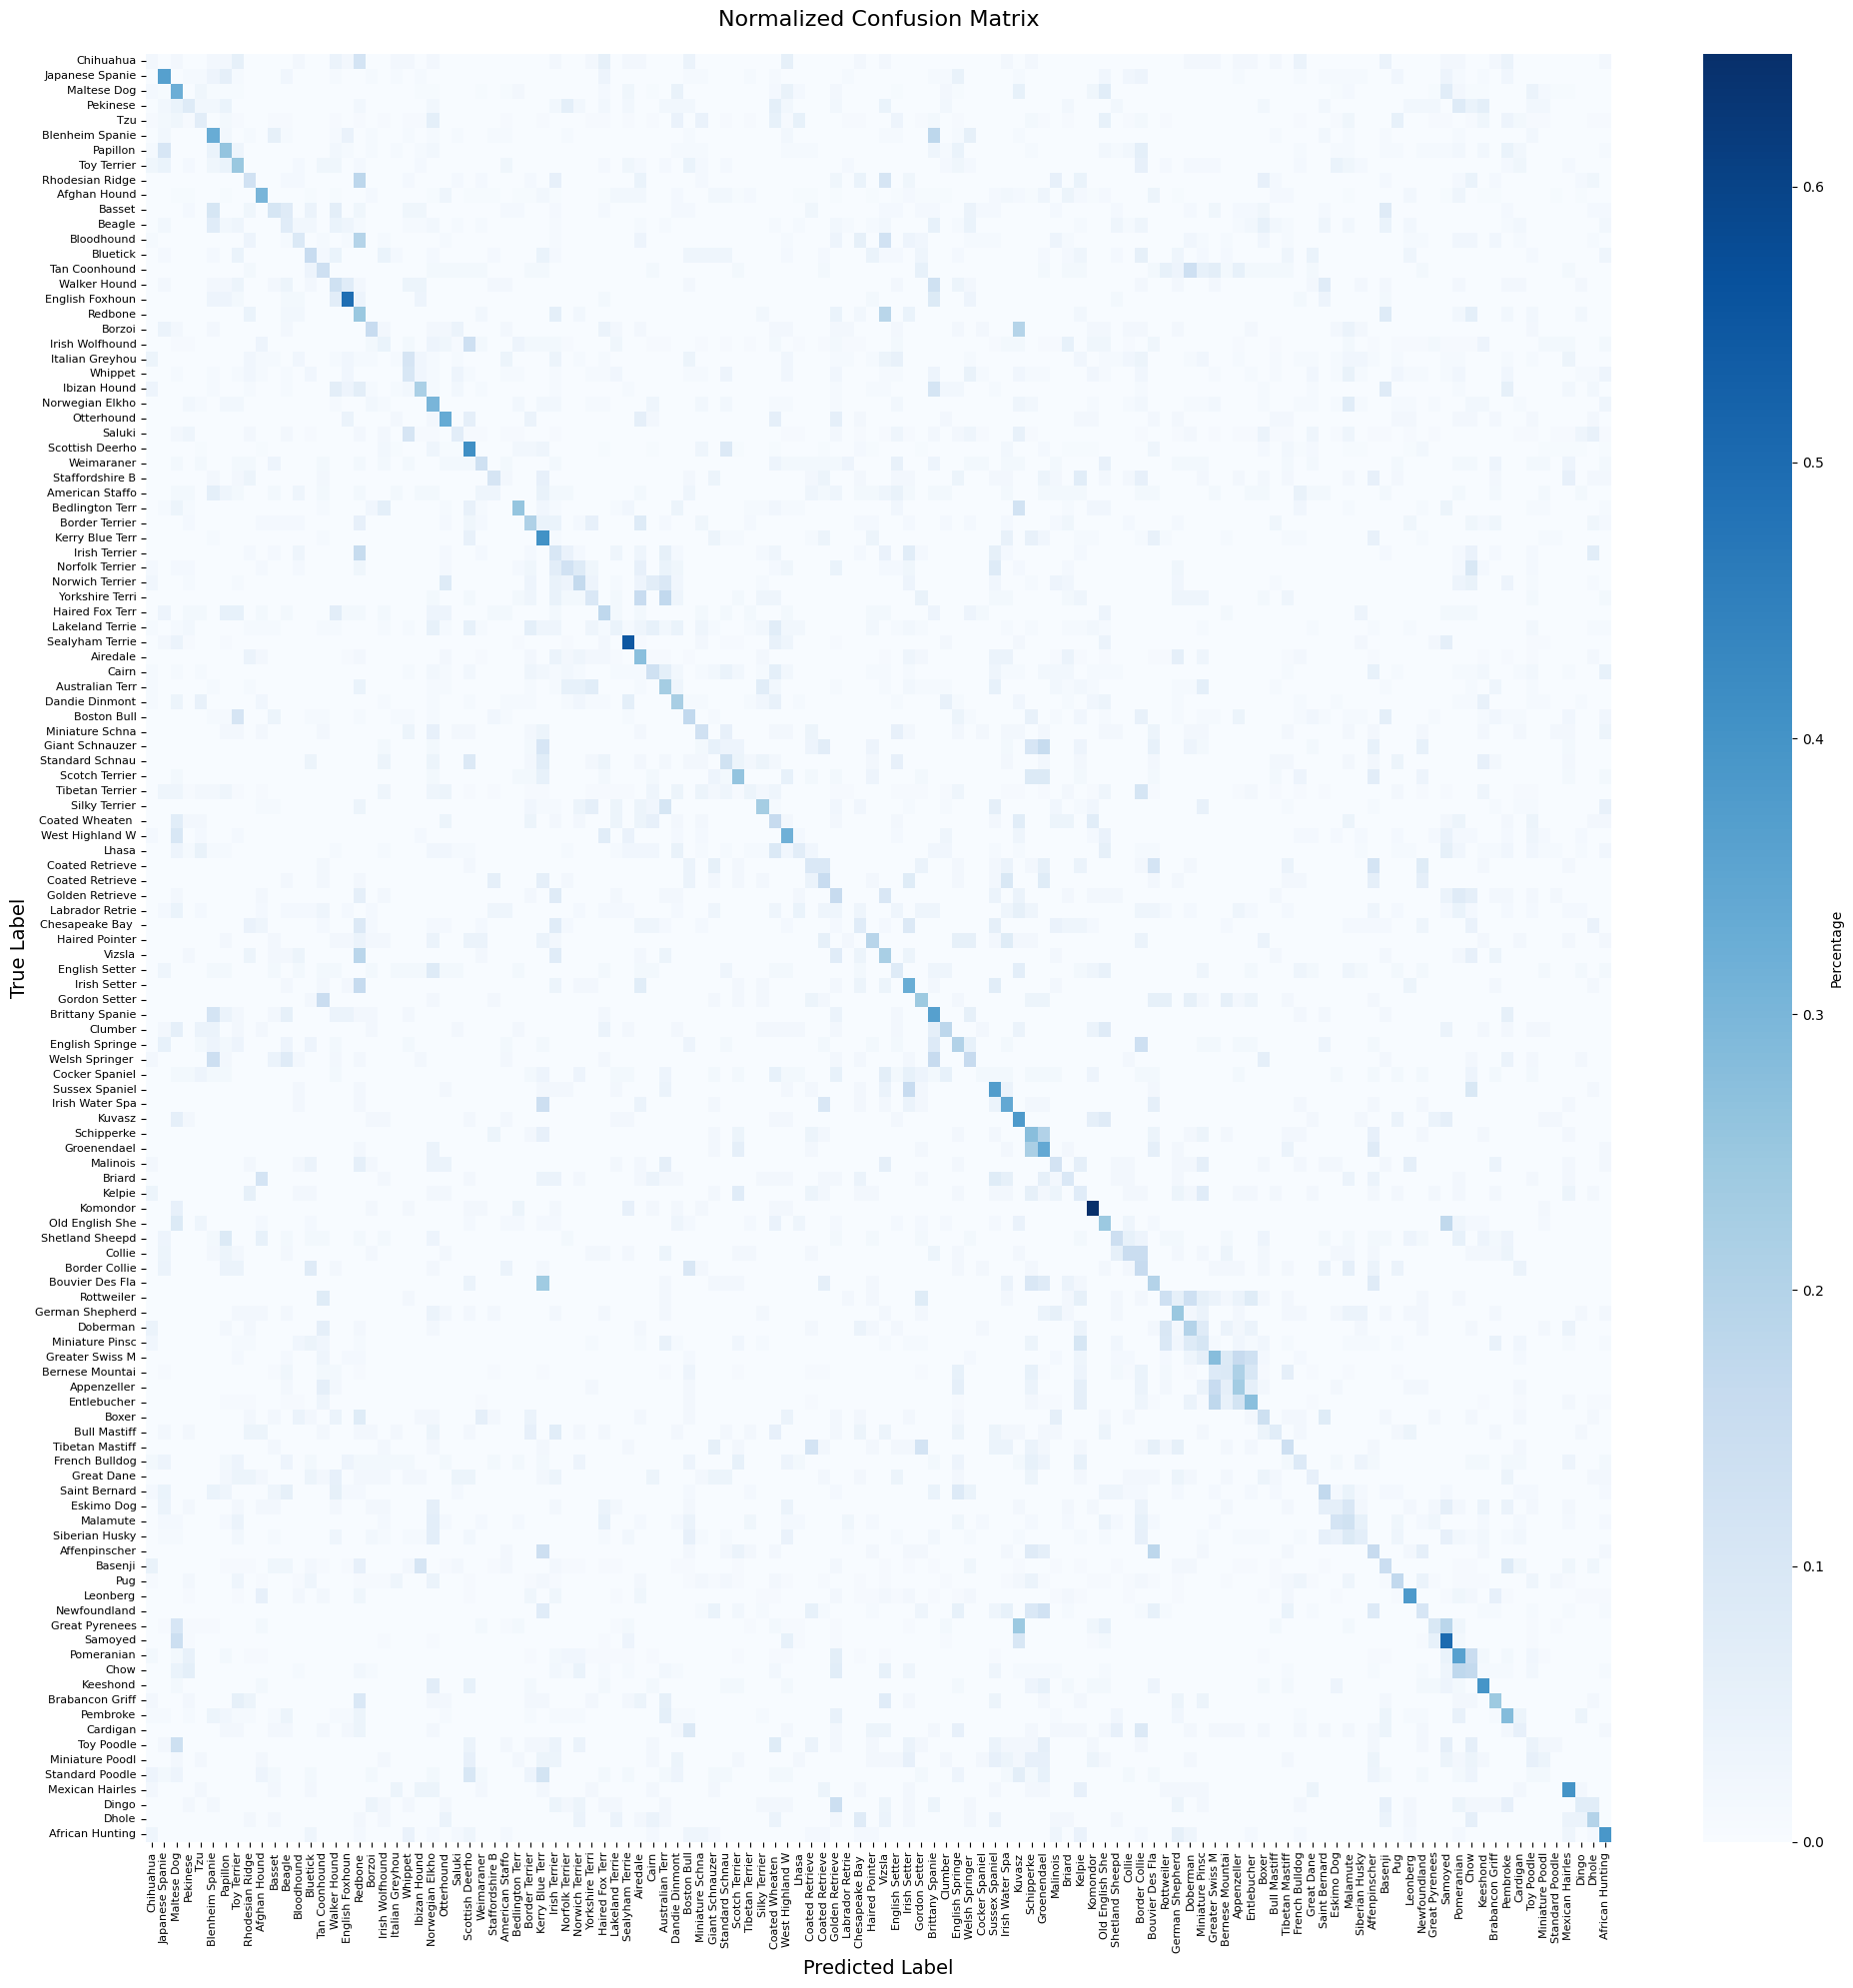


TOP 10 MOST CONFUSED BREED PAIRS
True Breed                Predicted As              Count     
------------------------------------------------------------
Great Pyrenees            Kuvasz                    0.24778761061946902
Bouvier Des Flandres      Kerry Blue Terrier        0.24      
Groenendael               Schipperke                0.22      
Bernese Mountain Dog      Appenzeller               0.211864406779661
Schipperke                Groenendael               0.2037037037037037
Borzoi                    Kuvasz                    0.19607843137254902
Bloodhound                Redbone                   0.19540229885057472
Redbone                   Vizsla                    0.1875    
Great Pyrenees            Samoyed                   0.18584070796460178
Vizsla                    Redbone                   0.18518518518518517

WORST 10 PERFORMING BREEDS
Breed                          Accuracy     Correct    Total     
----------------------------------------------------------

/tmp/ipython-input-203012066.py:268: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([correct_confidences, incorrect_confidences],


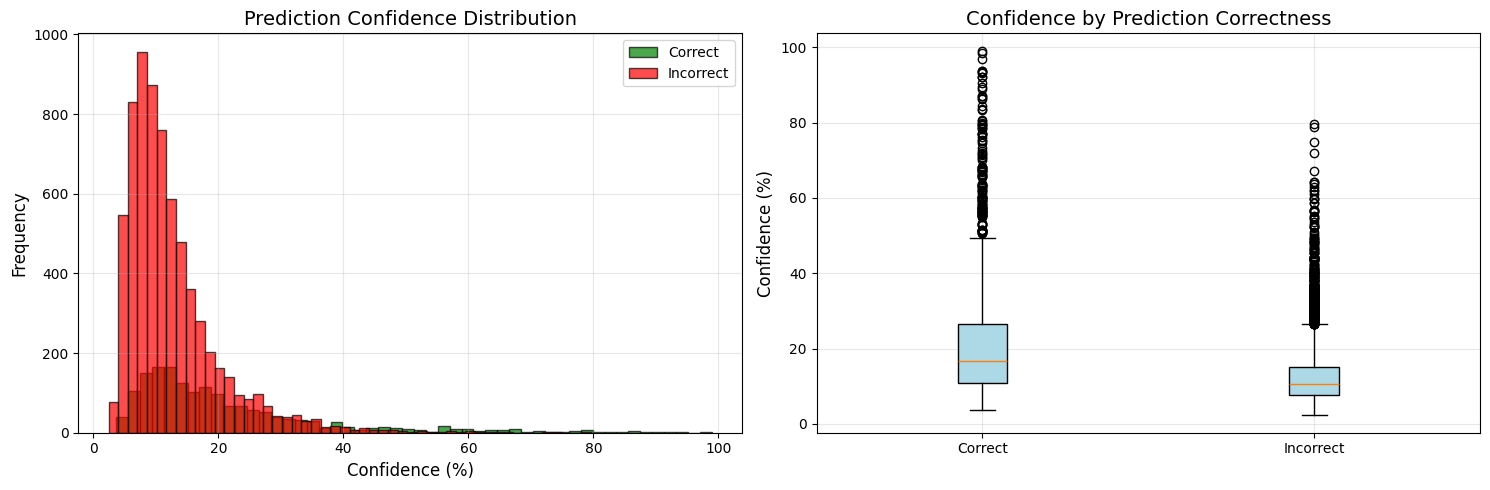


CONFIDENCE STATISTICS
Correct Predictions:
  Mean Confidence: 21.75%
  Median Confidence: 16.67%
  Std Dev: 16.53%

Incorrect Predictions:
  Mean Confidence: 12.64%
  Median Confidence: 10.53%
  Std Dev: 7.89%

SUMMARY STATISTICS
Overall Accuracy:    19.43%
Macro Precision:     0.1814
Macro Recall:        0.1892
Macro F1-Score:      0.1762
Total Samples:       8580

✅ Comprehensive evaluation complete!


In [14]:
comprehensive_evaluation(
    model=model,
    test_loader=test_loader,
    breed_labels=BREED_LABELS,
    model_name="CNN"
)